In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
import glob

# Configuração do Seaborn
sns.set(style="whitegrid")

In [42]:
# Função para carregar os dados de múltiplos arquivos CSV
def load_data(file_path_pattern):
    all_files = glob.glob(file_path_pattern)
    df_list = []
    for file in all_files:
        df = pd.read_csv(file, delimiter=';')
        df_list.append(df)
    data = pd.concat(df_list, ignore_index=True)
    return data

In [43]:
# Função para pré-processar os dados
def preprocess_data(data):
    data = pd.get_dummies(data, columns=['setor', 'codigo', 'acao', 'tipo'])
    data = data.drop(columns=['date'])
    data = data.dropna(axis=1, how='all')
    imputer = SimpleImputer(strategy='mean')
    data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    return data

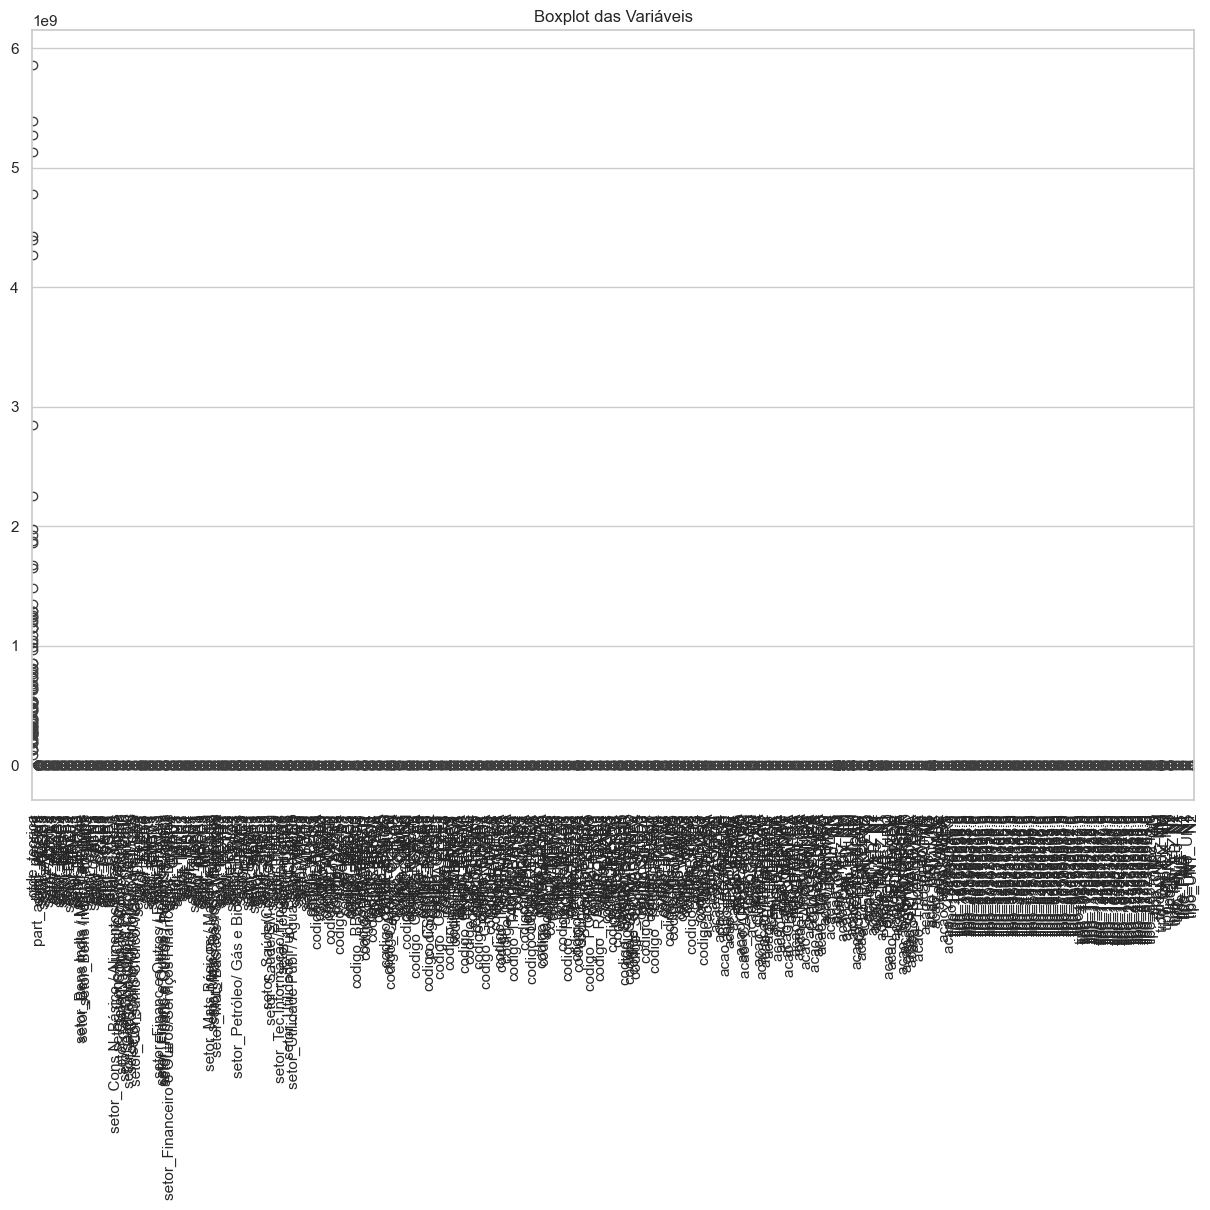

In [44]:
# Carregar e pré-processar os dados
file_path_pattern = '../01_elt_etl/bovespa/*.csv'
data = load_data(file_path_pattern)
data = preprocess_data(data)

# Visualizar a distribuição dos dados com boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title('Boxplot das Variáveis')
plt.show()

Tamanho do conjunto de dados após a remoção de outliers: (8, 502)


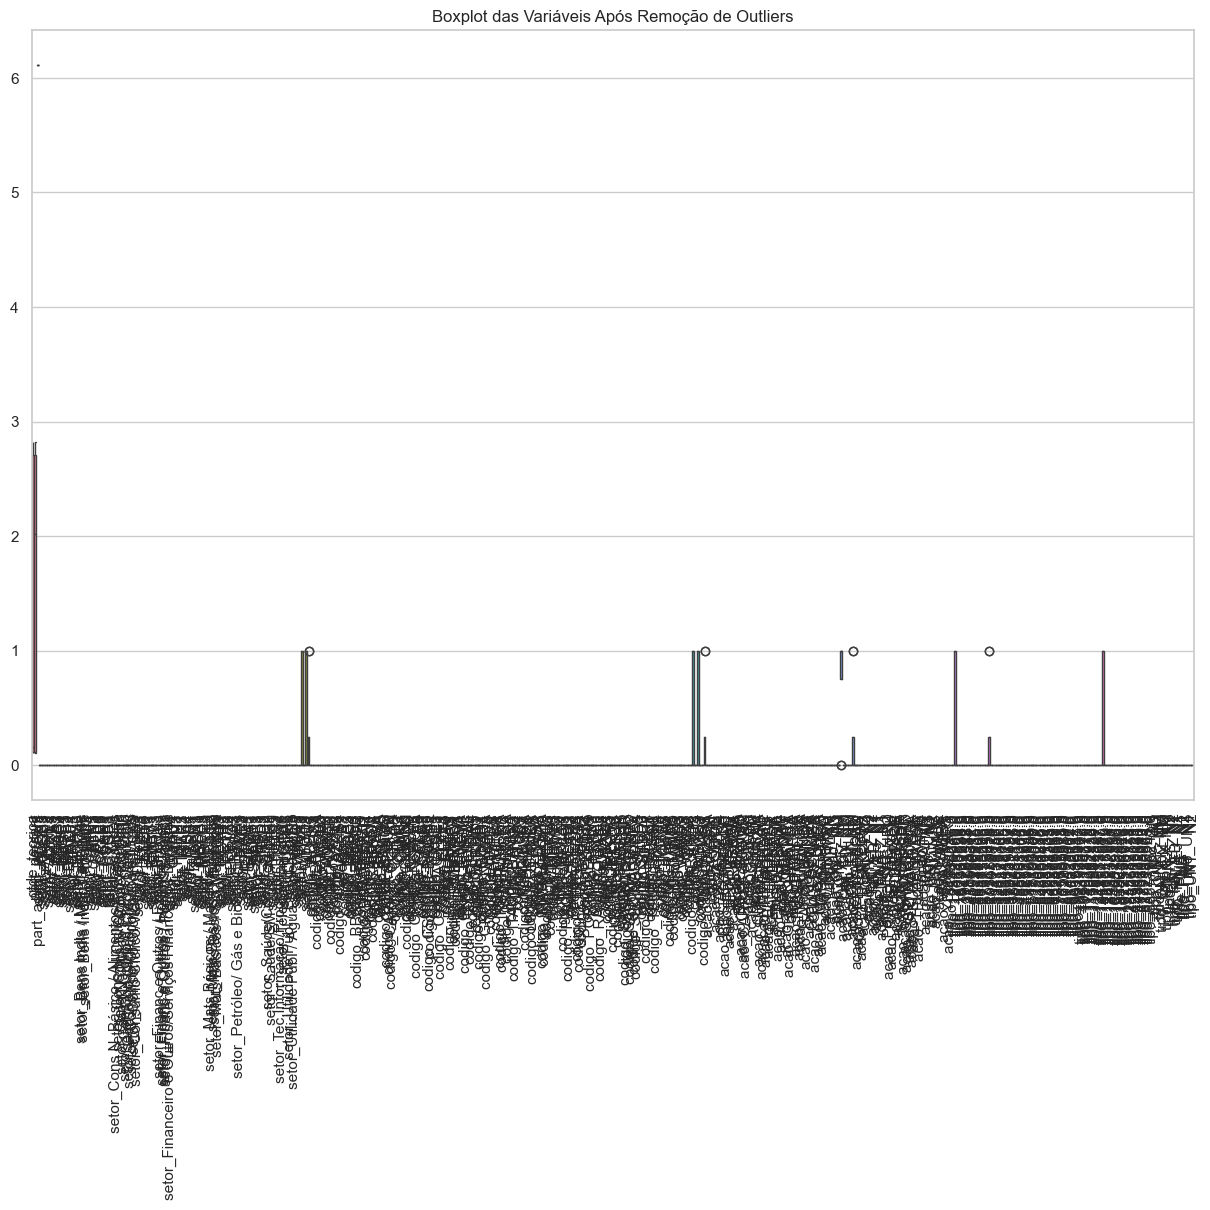

In [36]:
# Função para identificar e tratar outliers
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    #lower_bound = Q1 - 1.5 * IQR
    #upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 3 * IQR  # Ajuste o multiplicador conforme necessário
    upper_bound = Q3 + 3 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data


# Identificar e tratar outliers em todas as colunas numéricas
for column in data.select_dtypes(include=[np.number]).columns:
    data = remove_outliers(data, column)

# Verificar o tamanho do conjunto de dados após a remoção de outliers
print(f"Tamanho do conjunto de dados após a remoção de outliers: {data.shape}")

# Verificar a presença da coluna 'part_percent'
if 'part_percent' not in data.columns:
    raise ValueError("A coluna 'part_percent' não está presente no conjunto de dados após a remoção de outliers.")

# Visualizar a distribuição dos dados após a remoção de outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title('Boxplot das Variáveis Após Remoção de Outliers')
plt.show()

In [37]:

from sklearn.model_selection import KFold

# Função para treinar e avaliar o modelo
def train_and_evaluate_model(data, model_type='linear'):
    X = data.drop(columns=['part_percent'])
    y = data['part_percent']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'ridge':
        model = Ridge(alpha=1.0)
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1)
    elif model_type == 'decision_tree':
        model = DecisionTreeRegressor(random_state=42)
    elif model_type == 'xgboost':
        model = XGBRegressor(random_state=42)
    else:
        raise ValueError("Tipo de modelo não suportado: escolha 'linear', 'ridge', 'lasso', 'decision_tree' ou 'xgboost'")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Usa KFold para criar os folds ajustados
    cv_splits = max(2, min(5, len(X) // 2))  # Ajusta dinamicamente com base no tamanho do dataset
    kf = KFold(n_splits=cv_splits)

    # Validação cruzada
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    
    results = {
        'Modelo': model_type,
        'MSE': mse,
        'R²': r2,
        'MAE': mae,
        'MAPE': mape,
        'Cross-Validation R²': cv_scores.mean()
    }
    
    return results, y_test, y_pred

In [38]:
# Ajuste de hiperparâmetros do XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Criar o modelo XGBoost
xgb_model = XGBRegressor(random_state=42)

# Verificar o tamanho do conjunto de dados
X = data.drop(columns=['part_percent'])
y = data['part_percent']
print(f"Tamanho do conjunto de dados: {X.shape[0]} amostras")

# Ajustar o número de divisões (cv) para a validação cruzada
cv_splits = min(5, X.shape[0] // 2)  # Número de divisões não pode ser maior que o número de amostras dividido por 2

# Criar o GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv_splits, scoring='r2', n_jobs=-1)

# Ajustar o GridSearchCV aos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
best_params = grid_search.best_params_
print(f"Melhores hiperparâmetros: {best_params}")

# Treinar o modelo com os melhores hiperparâmetros
best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Avaliar o modelo ajustado
y_pred = best_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MSE: {mse}, R²: {r2}, MAE: {mae}, MAPE: {mape}")

Tamanho do conjunto de dados: 8 amostras


c:\Users\vfanj\Documents\FIAP_POS_ML\Fase03_Tech_Challenge\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Melhores hiperparâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
MSE: 0.698092271005732, R²: 0.5853343158032636, MAE: 0.8344028747081755, MAPE: 3.9665530312235266


In [40]:
# Treinar e avaliar os modelos
import pandas as pd

model_types = ['linear', 'ridge', 'lasso', 'decision_tree', 'xgboost']
results = []

for model_type in model_types:
    result, y_test, y_pred = train_and_evaluate_model(data, model_type=model_type)
    
    # Obter os índices originais de y_test para mapear 'codigo' e 'date'
    y_test_indices = y_test.index
    codigo_values = data.loc[y_test_indices, 'codigo'].values  # Códigos das ações
    date_values = data.loc[y_test_indices, 'date'].values     # Datas das ações

    # Adicionar códigos e datas ao resultado
    result['codigo'] = codigo_values
    result['date'] = date_values
    results.append(result)

# Concatenar todos os resultados em um único DataFrame
results_df = pd.concat(results, ignore_index=True)

# Salvar o DataFrame em CSV
output_path = 'C:/Users/vfanj/Documents/FIAP_POS_ML/Fase03_Tech_Challenge/bovespa-data-analysis/bovespa-data-analysis/resultados/model_results.csv'
results_df.to_csv(output_path, index=False)


ValueError: too many values to unpack (expected 3)

In [39]:
import pandas as pd

# Supondo que a função train_and_evaluate_model retorna um dicionário com as métricas e previsões
def train_and_evaluate_model(data, model_type):
    # Exemplo de retorno simulado
    return {
        'Modelo': [model_type]*len(data),  # Repetindo o tipo de modelo
        'MSE': np.random.rand(len(data)),  # Dados simulados
        'R²': np.random.rand(len(data)),
        'MAE': np.random.rand(len(data)),
        'MAPE': np.random.rand(len(data)),
        'Cross-Validation R²': np.random.rand(len(data)),
        'y_pred': np.random.rand(len(data)),  # Previsões simuladas
        'y_test_index': data.index  # Índices dos dados de teste
    }

# Carregar dados de exemplo
data = pd.DataFrame({
    'codigo': np.random.choice(['WEGE3', 'EMBR3', 'POMO4'], size=100),
    'feature1': np.random.rand(100),
    'feature2': np.random.rand(100),
    'target': np.random.rand(100)
})

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(
    data[['feature1', 'feature2']], data['target'], test_size=0.2, random_state=42
)

model_types = ['linear', 'ridge', 'lasso', 'decision_tree', 'xgboost']
results = []

for model_type in model_types:
    model_result = train_and_evaluate_model(X_test, model_type)
    result_df = pd.DataFrame(model_result)
    result_df['codigo'] = data.loc[model_result['y_test_index'], 'codigo'].values  # Adicionando código usando índices
    results.append(result_df)

# Concatenar todos os resultados em um único DataFrame
results_df = pd.concat(results, ignore_index=True)

# Salvar o DataFrame em CSV
output_path = 'C:/Users/vfanj/Documents/FIAP_POS_ML/Fase03_Tech_Challenge/bovespa-data-analysis/bovespa-data-analysis/resultados/model_results.csv'
results_df.to_csv(output_path, index=False)


In [29]:
# Treinar e avaliar os modelos
model_types = ['linear', 'ridge', 'lasso', 'decision_tree', 'xgboost']
results = []

for model_type in model_types:
    # Treinar e avaliar o modelo
    result, y_test, y_pred = train_and_evaluate_model(data, model_type=model_type)
    
    # Garantir que os índices originais sejam usados para mapear 'codigo'
    y_test_indices = y_test.index  # Índices originais de y_test
    codigo_values = data.loc[y_test_indices, 'codigo'].values  # Mapear os códigos correspondentes
    
    # Adicionar os códigos ao resultado
    if isinstance(result, dict):
        # Se 'result' for um dicionário, converta para DataFrame
        result_df = pd.DataFrame(result)
        result_df['codigo'] = codigo_values
        results.append(result_df)
    elif isinstance(result, pd.DataFrame):
        # Se 'result' já for um DataFrame
        result['codigo'] = codigo_values
        results.append(result)
    else:
        raise ValueError(f"Formato inesperado de 'result': {type(result)}")

# Concatenar todos os resultados em um único DataFrame
results_df = pd.concat(results, ignore_index=True)

# Salvar o DataFrame em CSV
output_path = r'C:\Users\vfanj\Documents\FIAP_POS_ML\Fase03_Tech_Challenge\bovespa-data-analysis\bovespa-data-analysis\resultados\model_results.csv'
results_df.to_csv(output_path, index=False)

KeyError: 'codigo'

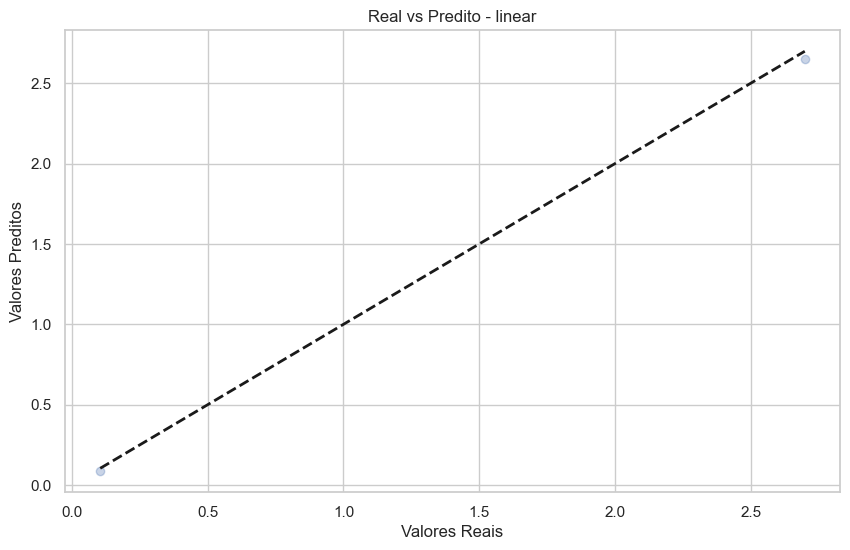

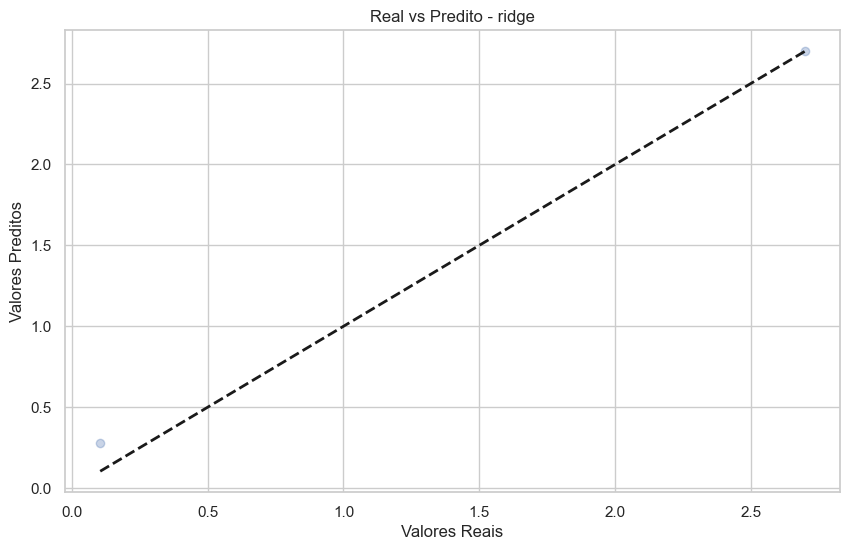

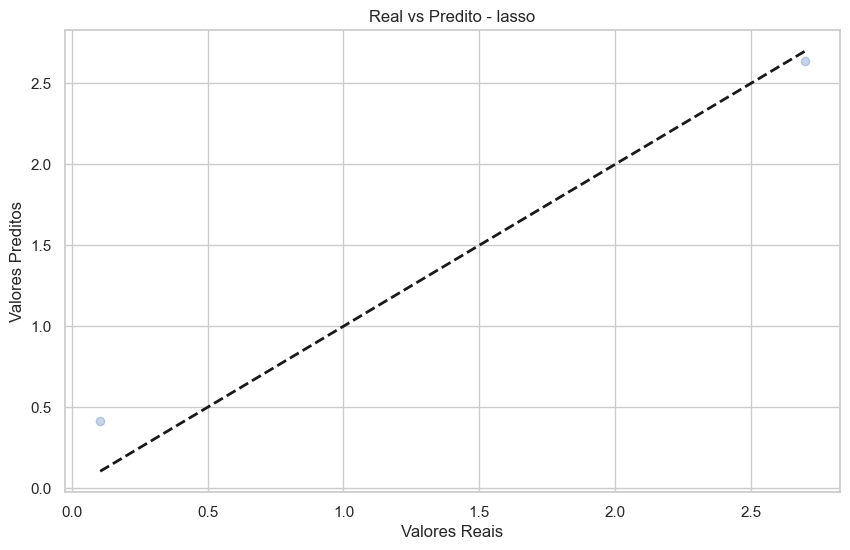

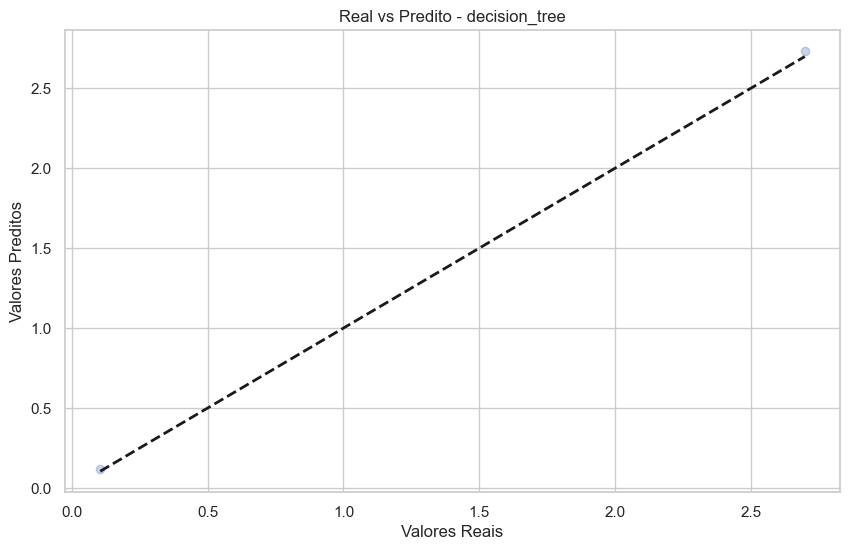

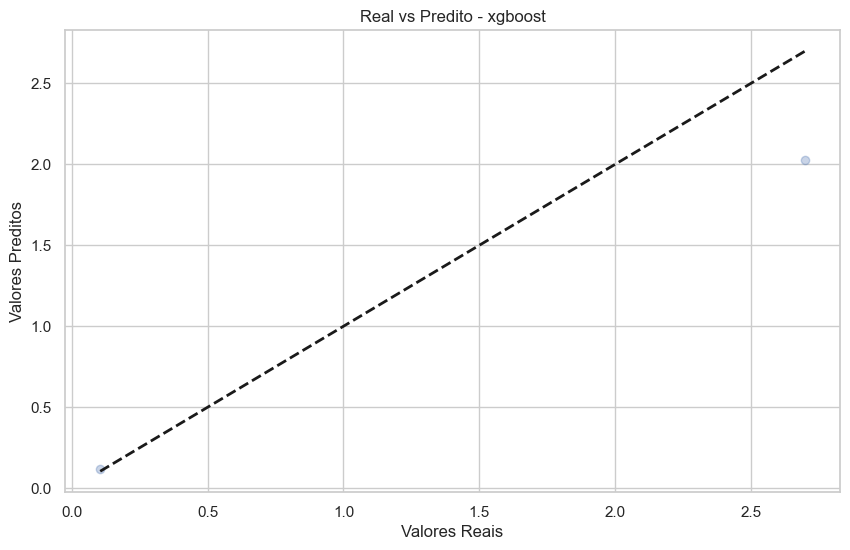

In [ ]:
# Treinar e avaliar os modelos
model_types = ['linear', 'ridge', 'lasso', 'decision_tree', 'xgboost']
results = []

for model_type in model_types:
    result, y_test, y_pred = train_and_evaluate_model(data, model_type=model_type)
    results.append(result)
    # Plotar os resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.title(f'Real vs Predito - {model_type}')
    plt.show()

In [ ]:
# Exibir os resultados
results_df = pd.DataFrame(results)
results_df

,Modelo,MSE,R²,MAE,MAPE,Cross-Validation R²
0,linear,0.001254,0.999255,0.032471,0.096866,0.990991
1,ridge,0.015593,0.990738,0.088622,0.849123,0.945033
2,lasso,0.049350,0.970686,0.183236,1.495445,0.807463
3,decision_tree,0.000617,0.999634,0.022500,0.063806,0.955649
4,xgboost,0.226648,0.865371,0.343057,0.187035,-3.183487
